# Importing Packages

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers, optimizers, applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from keras.applications.resnet50 import ResNet50

from sklearn.metrics import confusion_matrix

%reload_ext autoreload
%autoreload 2
from utils import *


# ResNet50

In [2]:
cnn_base = ResNet50(include_top = False,
                    weights = "imagenet",
                    input_shape = (256, 256, 3))
model = models.Sequential()
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))

cnn_base.trainable = False

In [3]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 214,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

Found 6840 images belonging to 2 classes.
Found 1506 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [4]:
X_test, y_test = next(test_generator)

In [5]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.001),
              metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='PR')])

In [9]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
tensorboard_cb = TensorBoard(log_dir = "../logresnet")
csv_logger = CSVLogger('../logresnet/log.csv')
history = model.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   epochs = 20,
                   callbacks = [earlyStopping, mcp_save, tensorboard_cb, csv_logger],
                   validation_data = val_generator,
                   validation_steps = len(val_generator))

Epoch 1/20
428/428 [==============================] - 2421s 6s/step - loss: 0.7569 - accuracy: 0.8007 - precision: 0.8230 - recall: 0.9394 - auc: 0.6511 - auc_1: 0.8174 - val_loss: 0.4460 - val_accuracy: 0.8645 - val_precision: 0.8645 - val_recall: 1.0000 - val_auc: 0.5000 - val_auc_1: 0.8645
Epoch 2/20
322/428 [=====================>........] - ETA: 8:26 - loss: 0.5607 - accuracy: 0.7545 - precision: 0.7545 - recall: 1.0000 - auc: 0.4895 - auc_1: 0.7505

KeyboardInterrupt: 

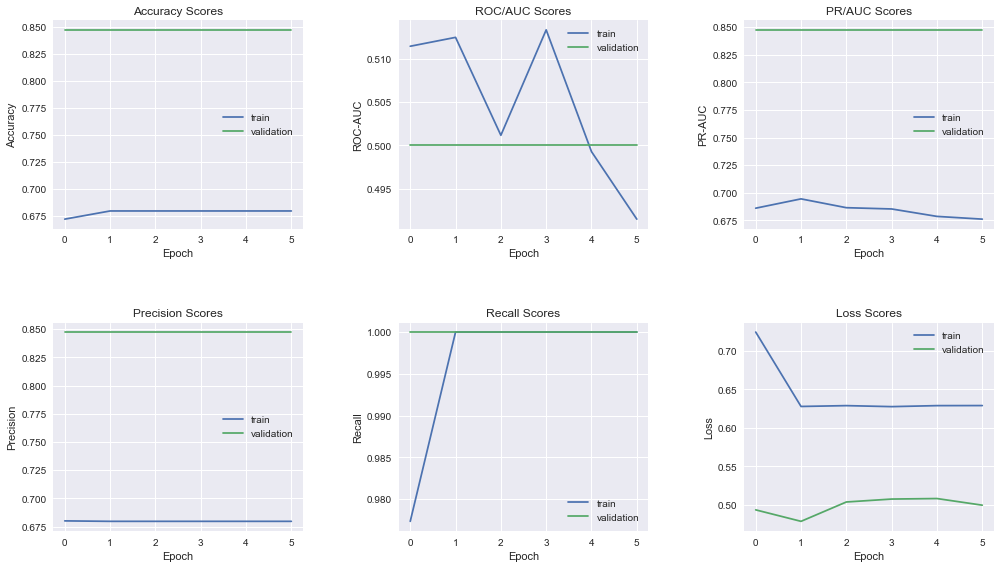

In [8]:
plt.style.use('seaborn')
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df

,loss,accuracy,precision,recall,auc,auc_1,val_loss,val_accuracy,val_precision,val_recall,val_auc,val_auc_1
0,0.724215,0.672063,0.680032,0.977334,0.511431,0.686060,0.493600,0.847458,0.847458,1.0,0.5,0.847458
1,0.627716,0.679634,0.679634,1.000000,0.512455,0.694484,0.478725,0.847458,0.847458,1.0,0.5,0.847458
2,0.628796,0.679634,0.679634,1.000000,0.501155,0.686503,0.503823,0.847458,0.847458,1.0,0.5,0.847458
3,0.627492,0.679634,0.679634,1.000000,0.513322,0.685356,0.507617,0.847458,0.847458,1.0,0.5,0.847458
4,0.628800,0.679634,0.679634,1.000000,0.499268,0.678630,0.508290,0.847458,0.847458,1.0,0.5,0.847458
5,0.628879,0.679634,0.679634,1.000000,0.491476,0.676151,0.499684,0.847458,0.847458,1.0,0.5,0.847458


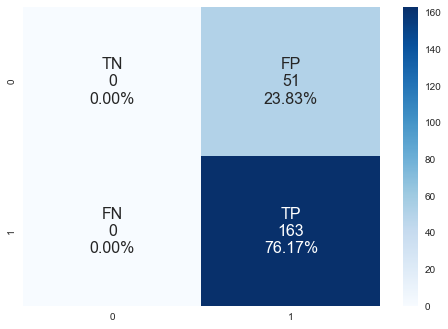

In [11]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

# AlexNet

In [10]:
model2 = AlexNet()
model2.compile(loss = 'binary_crossentropy',
               optimizer = Adam(lr = 0.001),
               metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [10]:
filepath = '../models/Alexnet.h5'
# earlyStopping = EarlyStopping(monitor = 'val_loss', verbose = 0, mode = 'min', patience = 4)
mcp_save = ModelCheckpoint(filepath, save_best_only = True, monitor = 'val_loss', mode = 'min')
tensorboard_cb = TensorBoard(log_dir = "../logalexnet")
csv_logger = CSVLogger('../logalexnet/log.csv')
history2 = model2.fit(train_generator,
                     steps_per_epoch = len(train_generator),
                     epochs = 20,
                     callbacks = [mcp_save, tensorboard_cb, csv_logger],
                     validation_data = val_generator,
                     validation_steps = len(val_generator))


SyntaxError: invalid syntax (<ipython-input-10-a65c3d09b19e>, line 7)

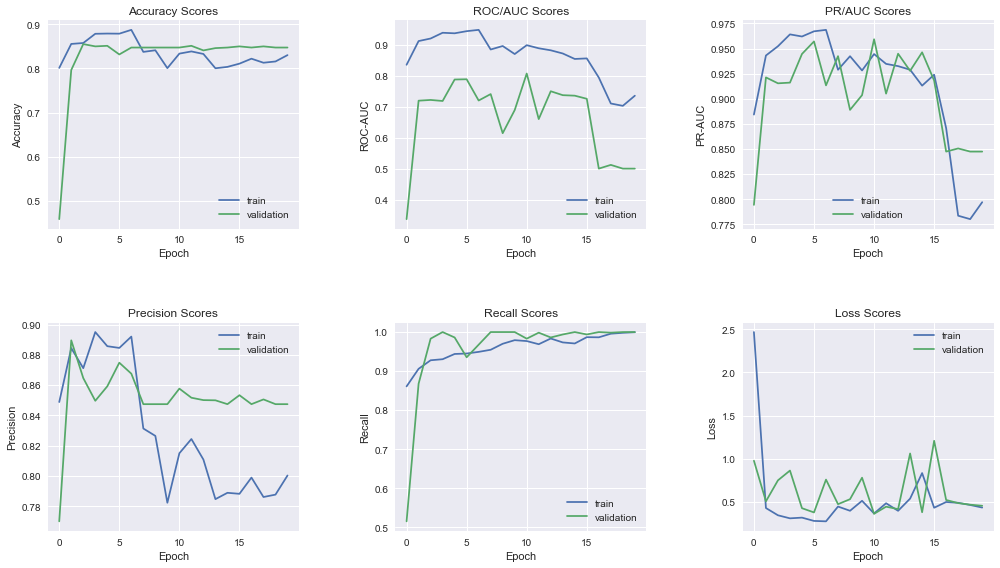

In [25]:
plt.style.use('seaborn')
sixplot(history2, 'auc_8', 'val_auc_8', 'auc_9', 'val_auc_9', 'precision_4', 'val_precision_4', 'recall_4', 'val_recall_4')

In [26]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,precision_4,recall_4,auc_8,auc_9,val_loss,val_accuracy,val_precision_4,val_recall_4,val_auc_8,val_auc_9
0,2.467961,0.801305,0.848864,0.860930,0.835079,0.884315,0.978353,0.458931,0.770115,0.515385,0.337002,0.794390
1,0.430359,0.855614,0.884471,0.905878,0.911570,0.943115,0.508132,0.796610,0.889590,0.867692,0.719198,0.921316
2,0.346347,0.857702,0.871212,0.927776,0.919823,0.952343,0.750981,0.855280,0.864682,0.983077,0.721584,0.915432
3,0.311021,0.878590,0.895048,0.930465,0.938372,0.964164,0.864334,0.850065,0.849673,1.000000,0.718238,0.916118
4,0.319276,0.879112,0.885725,0.943911,0.936615,0.962046,0.428347,0.851369,0.859249,0.986154,0.787475,0.944667
5,0.281081,0.878851,0.884574,0.945063,0.943490,0.967195,0.379417,0.831812,0.874820,0.935385,0.788330,0.957123
6,0.276291,0.887467,0.892058,0.949289,0.947721,0.968654,0.759521,0.847458,0.867586,0.967692,0.719744,0.913382
7,0.447464,0.837598,0.831382,0.954668,0.884350,0.928930,0.475080,0.847458,0.847458,1.000000,0.740519,0.942484
8,0.398637,0.841253,0.826514,0.970035,0.895625,0.942416,0.532740,0.847458,0.847458,1.000000,0.614267,0.888987
9,0.514087,0.800783,0.782382,0.979255,0.869681,0.928223,0.781494,0.847458,0.847458,1.000000,0.688889,0.903656


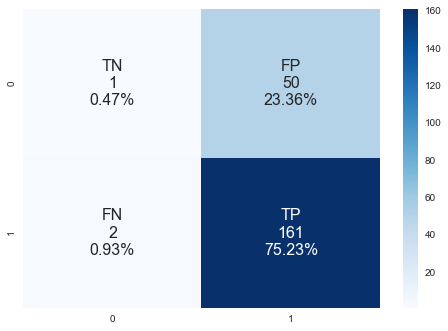

In [28]:
prob = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred2 = prob > 0.5
make_confusion_matrix(y_true, y_pred2)

In [33]:
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (227, 227),
        batch_size = 214,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

X_test, y_test = next(test_generator)

Found 214 images belonging to 2 classes.


In [34]:
score = model2.evaluate(X_test, y_test, verbose = 1)
labels = model2.metrics_names

print(str(labels[0]) + ": " + str(score[0]))
print(str(labels[1]) + ": " + str(score[1]))

7/7 [==============================] - 3s 249ms/step - loss: 0.5874 - accuracy: 0.7617 - precision_4: 0.7642 - recall_4: 0.9939 - auc_8: 0.5067 - auc_9: 0.7641
loss: 0.5873817205429077
accuracy: 0.7616822719573975
